# Reddit Climate Change - Visualization of results

Supervision: Prof. Dr. Jan Fabian Ehmke

Group members: Britz Luis, Huber Anja, Krause Felix Elias, Preda Yvonne-Nadine

Time: Summer term 2023 

Data: https://www.kaggle.com/datasets/pavellexyr/the-reddit-climate-change-dataset

In [1]:
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import matplotlib.colors as pltc

In [2]:
# Corporate Design
plt.rc('font', size=14)
plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams["font.family"] = "Arial"
cmap = pltc.LinearSegmentedColormap.from_list("", ["#01353B", "#8AE3ED"])
color = "#006871"

In [3]:
df = pd.read_csv("data/comments_final_labels.csv", header=0, index_col=0)

In [4]:
[i for i in df.topic_name.unique() if "kurzgesagt" in i]

['18_video_kurzgesagt_videos_channel']

In [5]:
df[[True if "kurzgesagt" in i else False for i in df.topic_name]].head(3)

,id,subreddit.name,subreddit.nsfw,created_utc,permalink,sentiment,score,created_date,created_day,created_month,created_year,created_time,topic_number,topic_name,topic_most_used_words,body_clean_full,climate_stance,emotion_small,emotion_large
942960,hqvjk8r,futurology,False,1.641085e+09,https://old.reddit.com/r/Futurology/comments/r...,0.0000,1.0,2022-01-02,2,1,2022,01:04:20,18,18_video_kurzgesagt_videos_channel,video - kurzgesagt - videos - channel - watch ...,People need to watch the Kurzgesagt video on c...,favor,neutral,neutral
943816,hr3xune,damnthatsinteresting,False,1.641237e+09,https://old.reddit.com/r/Damnthatsinteresting/...,-0.6114,2.0,2022-01-03,3,1,2022,19:13:36,18,18_video_kurzgesagt_videos_channel,video - kurzgesagt - videos - channel - watch ...,As long as everybody runs to the comments and ...,favor,disgust,neutral
944650,hrc6g0s,intellectualdarkweb,False,1.641379e+09,https://old.reddit.com/r/IntellectualDarkWeb/c...,0.9920,1.0,2022-01-05,5,1,2022,10:30:49,18,18_video_kurzgesagt_videos_channel,video - kurzgesagt - videos - channel - watch ...,;Well either the video gets it right the first...,none,neutral,disapproval


In [6]:
df.shape

(1041570, 19)

In [7]:
df = df[[False if "political climate" in i else True for i in df.body_clean_full]]
df.shape

(1033414, 19)

In [8]:
custom_iterator = iter(df[(df.created_year == 2022) & (df.topic_number == 18)].to_numpy())

In [9]:
df.head(3)

,id,subreddit.name,subreddit.nsfw,created_utc,permalink,sentiment,score,created_date,created_day,created_month,created_year,created_time,topic_number,topic_name,topic_most_used_words,body_clean_full,climate_stance,emotion_small,emotion_large
0,c0i14fb,askreddit,False,1.262306e+09,https://old.reddit.com/r/AskReddit/comments/ak...,0.7998,1.0,2010-01-01,1,1,2010,00:34:07,-1,-1_climate_people_global_warming,climate - people - global - warming - just - s...,"should be ""San Diego Weatherman has an opinion...",favor,surprise,NaN
1,c0i195b,worldnews,False,1.262313e+09,https://old.reddit.com/r/worldnews/comments/ak...,0.4754,0.0,2010-01-01,1,1,2010,02:30:18,0,0_people_just_climate_global,people - just - climate - global - don - like ...,Both Iggy and Harper would have marched us int...,favor,fear,neutral
2,c0i1a0w,environment,False,1.262314e+09,https://old.reddit.com/r/environment/comments/...,0.0242,1.0,2010-01-01,1,1,2010,02:54:40,0,0_people_just_climate_global,people - just - climate - global - don - like ...,"A man who though a moderate Tory , has a mixed...",favor,surprise,approval


In [10]:
curr = next(custom_iterator)
print(curr[0])
pprint.pprint(curr[15])
# 2013, topic 0, nr. 4

hqvjk8r
'People need to watch the Kurzgesagt video on climate change.'


## Total category distribution

<Axes: xlabel='climate_stance'>

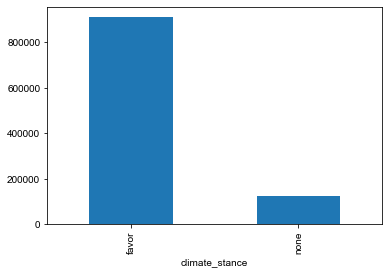

In [11]:
# Plot distribution
df.groupby(by="climate_stance").climate_stance.count().sort_values(ascending=False).plot.bar()

<Axes: xlabel='emotion_small'>

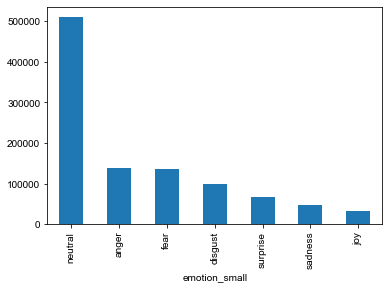

In [12]:
# Plot distribution
df.groupby(by="emotion_small").emotion_small.count().sort_values(ascending=False).plot.bar()

<Axes: xlabel='emotion_large'>

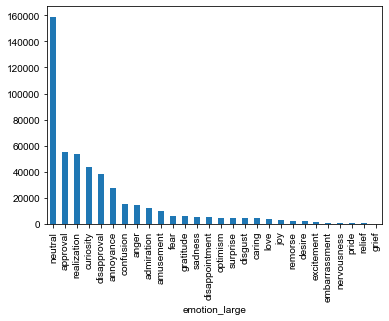

In [13]:
# Plot distribution
df.groupby(by="emotion_large").emotion_large.count().sort_values(ascending=False).plot.bar()

## Category distribution over time

In [14]:
df.groupby(by=["created_year", "emotion_large"]).count().id

created_year  emotion_large
2010          admiration        182
              amusement         129
              anger             143
              annoyance         431
              approval          836
                               ... 
2022          realization      5728
              relief             34
              remorse           220
              sadness           795
              surprise          499
Name: id, Length: 363, dtype: int64